In [1]:
# !pip install numpy
# !pip install transformers
# !pip install torch torchvision torchaudio
# !pip install seaborn
# !pip install seaborn[stats]
# !pip install matplotlib
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import warnings
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.exceptions import InconsistentVersionWarning
from sklearn.metrics import classification_report
%matplotlib inline

## Setup the device

In [2]:
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: Quadro RTX 8000


In [3]:
# Constants
LOADED_X_TRAIN = "LOADED_X_TRAIN"
LOADED_X_TEST = "LOADED_X_TEST"
LOADED_Y_TRAIN = "LOADED_Y_TRAIN"
LOADED_Y_TEST = "LOADED_Y_TEST"
LOADED_ORIGINAL_X_TRAIN = "LOADED_ORIGINAL_X_TRAIN"
LOADED_ORIGINAL_X_TEST = "LOADED_ORIGINAL_X_TEST"
LOADED_LABEL_ENCODER = "LOADED_LABEL_ENCODER"
NEWS_20 = "NEWS_20"
NEWS_AG = "NEWS_AG"
BOTH = "BOTH"

## IMPORTANT: SETUP DATASET BELOW

In [4]:
# SET TO BOTH, NEWS_20, OR NEWS_AG
DATASET = BOTH

In [16]:
class BERTModel():
    def __init__(self, dataset, x_train, y_train):
        self.dataset = dataset
        self.x_train = x_train
        self.y_train = y_train
        self.num_classes = 0
        self.batch_size = 32
        self.num_epochs = 4
        self.train_split = 0.9
        self.model_name = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
        self.training_stats = []

    def get_num_classes(self):
        if self.dataset == NEWS_20:
            self.num_classes = 20
        elif self.dataset == NEWS_AG:
            self.num_classes = 4
        else:
            self.num_classes = 24

    @staticmethod
    def set_seed():
        seed_val = 42
        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)
        torch.cuda.manual_seed_all(seed_val)

    @staticmethod
    def flat_accuracy(preds, labels):
        """
        Calculate the accuracy of our predictions vs labels
        """
        pred_flat = np.argmax(preds, axis=1).flatten()
        labels_flat = labels.flatten()
        return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
    def use_pretrained_bert(self):
        print('Training BERT model...')
        model = BertForSequenceClassification.from_pretrained(self.model_name, num_labels=self.num_classes)
        model.cuda()
        model.to(device)
        
        inputs = self.tokenizer(self.x_train.tolist(), 
                                padding=True, truncation=True, 
                                return_tensors="pt", 
                                max_length=128)
        
        
        
        
        labels = torch.tensor(self.y_train, dtype=torch.int64).to(device)
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)
        
        
        print("Input IDs size:", input_ids.size())
        print("Attention Mask size:", attention_mask.size())
        print("Labels size:", labels.size())

        dataset = TensorDataset(input_ids, attention_mask, labels)

        train_size = int(self.train_split * len(dataset))
        val_size = len(dataset) - train_size
        
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        print('{:>5,} training samples'.format(train_size))
        print('{:>5,} validation samples'.format(val_size))

        data_loader = DataLoader(
            train_dataset, 
            batch_size=self.batch_size, 
            shuffle=True
        )
        
        validation_dataloader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )

        # Setup optimizer and learning rate scheduler
        # Add eps?
        optimizer = AdamW(
            model.parameters(), 
            lr=2e-5
        )
        
        # Total number of training steps is [number of batches] x [number of epochs]
        total_steps = len(data_loader) * self.num_epochs
    
        # Create the learning rate scheduler
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)
        
        print("Length of the data_loader steps: " + str(len(data_loader)))
        
        for epoch in range(self.num_epochs):
            model.train()
            # Reset the total loss each step to re-calc avg for each epoch
            total_loss = 0
            for batch in data_loader:
                optimizer.zero_grad()
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)
                model.zero_grad()
                outputs = model(input_ids=input_ids, 
                                token_type_ids=None,
                                attention_mask=attention_mask, 
                                labels=labels)
                loss = outputs.loss
                # Perform a backward pass to calculate the gradients
                loss.backward()
                # Clip the norm of the gradients to 1.0.
                # Avoid exploding gradient problem
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                # Network gets told to update the parameters
                optimizer.step()
                # Update the learning rate
                scheduler.step()
                total_loss += loss.item()
            # Calculate the average loss over all of the batches
            average_loss = total_loss / len(data_loader)
            print(f"Epoch {epoch + 1}/{self.num_epochs}, Training Loss: {average_loss:.4f}")

            print("")
            print("Running Validation...")
        
            # Put the model in evaluation mode
            model.eval()
            
            total_eval_accuracy = 0
            total_eval_loss = 0
        
            # Evaluate data for one epoch
            for batch in validation_dataloader:
                input_ids = batch[0].to(device)
                input_mask = batch[1].to(device)
                labels = batch[2].to(device)
                
                # Tell pytorch not to bother with constructing the compute graph during
                # the forward pass, since this is only needed for backprop (training).
                with torch.no_grad():        
        
                    # Forward pass, calculate logit predictions.
                    outputs = model(input_ids, 
                                           token_type_ids=None, 
                                           attention_mask=input_mask,
                                           labels=labels)
                    
                # Accumulate the validation loss
                loss = outputs.loss
                logits = outputs.logits
                
                total_eval_loss += loss.item()
        
                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = labels.to('cpu').numpy()
        
                # Calculate the accuracy for this batch of test sentences, and
                # accumulate it over all batches
                total_eval_accuracy += self.flat_accuracy(logits, label_ids)
                
            # Report the final accuracy for this validation run
            avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
            print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
        
            # Calculate the average loss over all of the batches
            avg_val_loss = total_eval_loss / len(validation_dataloader)
            print("  Validation Loss: {0:.2f}".format(avg_val_loss))

            self.training_stats.append(
                {
                    'Epoch': epoch + 1,
                    'Training Loss': average_loss,
                    'Validation Loss': avg_val_loss,
                    'Validation Accuracy': avg_val_accuracy,
                }
            )
            
        print('BERT model trained')

        return model

    def table_training_stats(self):
        # Display floats with two decimal places
        pd.set_option('display.float_format', '{:.2f}'.format)
        
        # Create a DataFrame from our training statistics
        df_stats = pd.DataFrame(data=self.training_stats)
        
        # Use the 'epoch' as the row index.
        df_stats = df_stats.set_index('Epoch')
        
        # Display the table
        print(df_stats)
        
        return df_stats

    @staticmethod
    def plot_training_validation_loss(df_stats):
        # Use plot styling from seaborn.
        sns.set(style='darkgrid')
        
        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)
        
        # Plot the learning curve.
        plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
        plt.plot(df_stats['Validation Loss'], 'g-o', label="Validation")
        
        # Label the plot.
        plt.title("Training & Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.xticks([1, 2, 3, 4])
        
        plt.show()


In [7]:
    def load_features_labels_vocab(saved_original_data_file=None, 
                                   saved_labels_data_file=None, 
                                   saved_label_encoder_file=None):
        loaded_y_train = None
        loaded_y_test = None
        loaded_original_x_train = None
        loaded_original_x_test = None
        loaded_label_encoder = None
        
        if saved_original_data_file is not None:
            loaded_original_data = np.load(saved_original_data_file, allow_pickle=True)
            loaded_original_x_train = loaded_original_data['original_x_train']
            loaded_original_x_test = loaded_original_data['original_x_test']

        if saved_labels_data_file is not None:
            loaded_train_data = np.load(saved_labels_data_file, allow_pickle=True)
            loaded_y_train = loaded_train_data['y_train']
            loaded_y_test = loaded_train_data['y_test']

        if saved_label_encoder_file is not None:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=InconsistentVersionWarning)
                loaded_label_encoder = joblib.load(saved_label_encoder_file)
            
            
        loaded_data = {
            LOADED_Y_TRAIN: loaded_y_train,
            LOADED_Y_TEST: loaded_y_test,
            LOADED_ORIGINAL_X_TRAIN: loaded_original_x_train,
            LOADED_ORIGINAL_X_TEST: loaded_original_x_test,
            LOADED_LABEL_ENCODER: loaded_label_encoder
        }
        return loaded_data

In [26]:
saved_original_data_file = "CSE842/data/preprocess/original_data_" + DATASET + ".npz"
saved_labels_data_file = "CSE842/data/preprocess/labels_data_" + DATASET + ".npz"
saved_label_encoder_file= "CSE842/data/preprocess/label_encoder_" + DATASET + ".joblib"

loaded_data = load_features_labels_vocab(saved_original_data_file=saved_original_data_file, 
                                         saved_labels_data_file=saved_labels_data_file,
                                         saved_label_encoder_file=saved_label_encoder_file
                                        )
print("Loaded Original X Train\n")
print(loaded_data[LOADED_ORIGINAL_X_TRAIN])
print("\nLoaded Original X Test\n")
print(loaded_data[LOADED_ORIGINAL_X_TEST])
print("\nLoaded Y Train\n")
print(loaded_data[LOADED_Y_TRAIN])
print("\nLoaded Y Test\n")
print(loaded_data[LOADED_Y_TEST])

Loaded Original X Train

['valentin vulihman vulih ipmce su subject attractive drawing sphere lines reply to vulih ipmce su organization inst prec mech comp equip moscow russia made attractive program at computer drawing sphere pasting paper children artists education send example alt source wanted see rotation sphere interested children design tesselations many famous regular polyhedra without serious difficaltis print patterns paste spherical models moscow tel clock mail valentin vulihman'
 'dbd urartu sdpa org david davidian subject turkish government agents usenet lie teeth article urartu apr organization center regional studies lines revision history zuma uucp posted turkish government agents guise sera zuma uucp serdar argic lie response article apr urartu sdpa org hla urartu sdpa org scribed orhan gunduz blown up gunduz receives ultimatum either gives honorary position executed refuses responsibility claimed jcag sdpa may cambridge massachusetts orhan gunduz turkish honorary con

## Find Max Sentence Length

In [9]:
def find_max_sentence_length(b_tokenizer):
    max_len_train = 0
    
    # For every sentence...
    for sent in loaded_data[LOADED_ORIGINAL_X_TRAIN]:
    
        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = b_tokenizer.encode(sent, add_special_tokens=True)
    
        # Update the maximum sentence length.
        max_len_train = max(max_len_train, len(input_ids))
    
    print('Max sentence length train: ', max_len_train)

    max_len_test = 0
    
    for sent in loaded_data[LOADED_ORIGINAL_X_TEST]:
    
        # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
        input_ids = b_tokenizer.encode(sent, add_special_tokens=True)
    
        # Update the maximum sentence length.
        max_len_test = max(max_len_test, len(input_ids))
    
    print('Max sentence length train: ', max_len_test)

## Train the BERT Model

In [17]:
BertModel = BERTModel(DATASET, loaded_data[LOADED_ORIGINAL_X_TRAIN], loaded_data[LOADED_Y_TRAIN])
BertModel.set_seed()

find_max_sentence_length(BertModel.tokenizer)

BertModel.get_num_classes()
bertModel = BertModel.use_pretrained_bert()

Token indices sequence length is longer than the specified maximum sequence length for this model (1956 > 512). Running this sequence through the model will result in indexing errors


Max sentence length train:  13494
Max sentence length train:  28717
Training BERT model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Input IDs size: torch.Size([23314, 128])
Attention Mask size: torch.Size([23314, 128])
Labels size: torch.Size([23314])
20,982 training samples
2,332 validation samples
Length of the data_loader steps: 656
Epoch 1/4, Training Loss: 1.1183

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.54
Epoch 2/4, Training Loss: 0.4254

Running Validation...
  Accuracy: 0.89
  Validation Loss: 0.38
Epoch 3/4, Training Loss: 0.2578

Running Validation...
  Accuracy: 0.90
  Validation Loss: 0.34
Epoch 4/4, Training Loss: 0.1793

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.34
BERT model trained


## Visualize the Training and Validation Loss

In [18]:
df_stats = BertModel.table_training_stats()

       Training Loss  Validation Loss  Validation Accuracy
Epoch                                                     
1               1.12             0.54                 0.84
2               0.43             0.38                 0.89
3               0.26             0.34                 0.90
4               0.18             0.34                 0.91


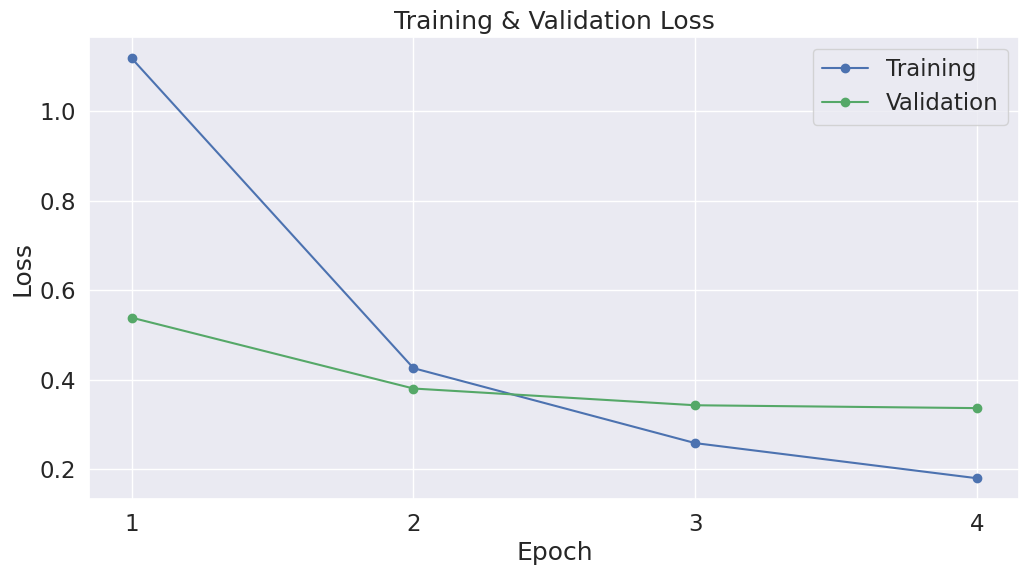

In [19]:
BertModel.plot_training_validation_loss(df_stats)

## Evaluate Performance on Test Set

In [20]:
x_test = loaded_data[LOADED_ORIGINAL_X_TEST]
y_test = loaded_data[LOADED_Y_TEST]

tokenized_test = BertModel.tokenizer(x_test.tolist(), padding=True, truncation=True, return_tensors="pt", max_length=128)

labels = torch.tensor(y_test, dtype=torch.int64).to(device)
input_ids = tokenized_test["input_ids"].to(device)
attention_mask = tokenized_test["attention_mask"].to(device)

batch_size = 32 

prediction_data = TensorDataset(input_ids, attention_mask, labels)
prediction_dataloader = DataLoader(prediction_data, batch_size=batch_size, shuffle=True)

In [29]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
bertModel.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bertModel(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = outputs.logits
    label_ids = b_labels.to('cpu').numpy()
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    
    # Store predictions and true labels
    predictions.append(preds)
    true_labels.append(label_ids)

print('DONE.')

Predicting labels for 15,132 test sentences...
DONE.


In [32]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

label_encoder = loaded_data[LOADED_LABEL_ENCODER]


print("The models predictions...")
print(label_encoder.inverse_transform(flat_predictions))
print("\nThe test predictions...")
print(label_encoder.inverse_transform(flat_true_labels))
print("\n")

final_report = classification_report(label_encoder.inverse_transform(flat_true_labels),
                      label_encoder.inverse_transform(flat_predictions))
print(final_report)

The models predictions...
['World' 'World' 'Sports' ... 'talk.politics.mideast' 'rec.autos'
 'alt.atheism']

The test predictions...
['World' 'World' 'Sports' ... 'talk.politics.mideast' 'rec.autos'
 'alt.atheism']


                          precision    recall  f1-score   support

                Business       0.86      0.85      0.86      1900
                Sci/Tech       0.87      0.87      0.87      1900
                  Sports       0.96      0.98      0.97      1900
                   World       0.92      0.90      0.91      1900
             alt.atheism       0.74      0.69      0.71       319
           comp.graphics       0.76      0.73      0.75       389
 comp.os.ms-windows.misc       0.79      0.78      0.79       394
comp.sys.ibm.pc.hardware       0.66      0.73      0.69       392
   comp.sys.mac.hardware       0.80      0.81      0.80       385
          comp.windows.x       0.85      0.77      0.81       395
            misc.forsale       0.86      0.84      0.85 